<div class="alert alert-block alert-info">

- [Import the needed libraries](#2nd-bullet)<br>
- [Import the dataset](#3rd-bullet)<br>
    
- [Filter methods](#6th-bullet)<br>
    - [Univariate variables](#7th-bullet)<br>
    - [Correlation Indices](#8th-bullet)<br>
    - [Chi-Square](#9th-bullet)<br>
- [Wrapper Methods](#10th-bullet)<br>
    - [RFE](#11th-bullet)<br>
        - [RFE Logistic Reg.](#12th-bullet)<br>
        - [RFE XGBoostClassifier.](#12th-bullet)<br>
- [Embedded Methods](#13th-bullet)<br>
    - [Lasso](#14th-bullet)<br>
- [Final Insights](#15th-bullet)<br>
    
</div>

# Chiel make the threshold between 0 and 0.2 dor correlation matrixes

<a class="anchor" id="2nd-bullet">

### Import the needed libraries
    
</a>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # setting seaborn default for plots

# data partition
from sklearn.model_selection import train_test_split


#filter methods
# spearman
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBClassifier

# embedded methods
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest  # mutual information is a embedded method for regression problems

# model assessment
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')


<a class="anchor" id="3rd-bullet">

### Import the dataset
    
</a>

In [48]:
preproc_train = pd.read_csv('../traindf.csv')

preproc_val = pd.read_csv('../valdf.csv')

preproc_test = pd.read_csv('../testdf.csv')


In [49]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder on the training data
label_encoder.fit(preproc_train['Claim Injury Type'])

# Transform the 'Claim Injury Type' column in both training and validation sets
preproc_train['Claim Injury Type'] = label_encoder.transform(preproc_train['Claim Injury Type'])
preproc_val['Claim Injury Type'] = label_encoder.transform(preproc_val['Claim Injury Type'])

In [50]:
y_preproc_train = preproc_train['Claim Injury Type']
X_preproc_train = preproc_train.drop(['Claim Injury Type'], axis=1)

y_preproc_val = preproc_val['Claim Injury Type']
X_preproc_val = preproc_val.drop(['Claim Injury Type'], axis=1)

In [51]:
X_preproc_train.shape, X_preproc_val.shape

((459220, 43), (114805, 43))

In [52]:

# #passar o claim identifier para o index

# y_preproc_train_copy = y_preproc_train.copy()

# y_preproc_train.set_index('Claim Identifier', inplace=True)

# y_preproc_val.set_index('Claim Identifier', inplace=True)

# X_preproc_train.set_index('Claim Identifier', inplace=True)

# preproc_test.set_index('Claim Identifier', inplace=True)

# X_preproc_val.set_index('Claim Identifier', inplace=True)


In [53]:
# drop Accident Month and Accident Day

X_preproc_train.drop(columns=['Accident Month', 'Accident Day'], inplace=True)
X_preproc_val.drop(columns=['Accident Month', 'Accident Day'], inplace=True)
preproc_test.drop(columns=['Accident Month', 'Accident Day'], inplace=True)

In [54]:
col_fill_median = ['Accident Month Cos', 'Accident Month Sin', 'Accident Day Cos', 'Accident Day Sin']

for col in col_fill_median:
    median_value = X_preproc_train[col].median()

    X_preproc_train[col].fillna(median_value, inplace=True)
    X_preproc_val[col].fillna(median_value, inplace=True)
    preproc_test[col].fillna(median_value, inplace=True)



In [55]:
#check for nan values
X_preproc_train.isna().sum().sort_values()

Assembly Date                       0
Above_65                            0
Accident Month Sin                  0
Accident Month Cos                  0
Accident Day Sin                    0
Accident Day Cos                    0
Received_C2                         0
Received_C3                         0
Hearing_held                        0
Attorney/Representative_Y           0
COVID-19 Indicator_Y                0
Alternative Dispute Resolution_Y    0
Gender_M                            0
wcio_pca1                           0
wcio_pca2                           0
region_cluster                      0
high_risk_nature                    0
high_risk_body                      0
Age_41_65                           0
high_risk_cause                     0
Age_21_40                           0
Days_to_Assembly                    0
Average Weekly Wage                 0
Birth Year                          0
C-2 Date                            0
C-3 Date                            0
Carrier Name

<div class="alert alert-block alert-success">

<a class="anchor" id="5th-bullet">    
    
## Feature Selection
    
</a>
    
</div>

<a class="anchor" id="6th-bullet">

## Filter methods
    
</a>

<a class="anchor" id="7th-bullet">

### Univariate variables
    
</a>

Check if any of the numerical variables is univariate (variance is equal to 0), then drop those variables if any of those exist.

from this we can tell that, there are no categorical features

In [22]:
X_preproc_train.var().sort_values()

Alternative Dispute Resolution_Y    0.004483
Under_20                            0.015444
Received_C2                         0.024602
Days_to_Assembly                    0.029170
Above_65                            0.036877
Agreement Reached                   0.044311
COVID-19 Indicator_Y                0.045801
high_risk_body                      0.047649
high_risk_cause                     0.101894
high_risk_nature                    0.116881
market_indicator                    0.143677
Hearing_held                        0.193621
Attorney/Representative_Y           0.216414
Received_C3                         0.219666
Gender_M                            0.242912
Age_21_40                           0.244430
Age_41_65                           0.250000
IME-4 Count                         1.000002
Accident Year                       1.000002
C-3 Date                            1.000002
WCIO Part Of Body Code              1.000002
Carrier Type                        1.000002
C-2 Date  

No feature to be dropped from this one

<a class="anchor" id="8th-bullet">

### Correlation indices
    
</a>

In [56]:
X_preproc_train.head()



,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,...,COVID-19 Indicator_Y,Alternative Dispute Resolution_Y,Gender_M,wcio_pca1,wcio_pca2,region_cluster,high_risk_nature,high_risk_body,high_risk_cause,market_indicator
0,-0.067360,1.213328,-0.495974,-0.064860,-1.263841,-0.575548,0.983139,1.274579,1.046863,-0.037533,...,0,0,0,0.610477,0.806579,0.162263,1,0,0,1
1,-0.908646,1.344678,0.955044,-0.783603,0.558209,-0.494377,-0.780636,0.384500,1.046863,-1.477658,...,0,0,0,-0.175047,0.713979,0.277415,0,0,1,1
2,1.012027,-0.755254,-0.133220,0.864313,0.558209,-0.209935,0.983139,1.040655,1.046863,-0.037533,...,0,0,1,-0.025755,0.530618,1.125027,0,0,0,0
3,0.056452,-0.755254,1.317798,0.041721,0.558209,-0.625062,-1.524399,1.040655,1.046863,-0.037533,...,0,0,1,-0.467459,-0.375868,-0.223555,0,0,0,0
4,-0.788009,0.889468,0.156984,-0.698884,-1.896900,-0.453747,-1.524399,0.574898,1.046863,-1.413414,...,0,0,1,0.104639,0.995235,0.774823,0,0,0,0


In [24]:
#drop binary columns
continuous_features = X_preproc_train.drop(columns=['COVID-19 Indicator_Y', 'Alternative Dispute Resolution_Y', 'Gender_M', 'high_risk_nature', 'Received_C2', 'Received_C3', 'Hearing_held', 'Attorney/Representative_Y', 'high_risk_body', 'high_risk_cause', 'market_indicator', 'Agreement Reached'])

In [25]:
# round to 1 decimal places
continuous_features = continuous_features.round(1)
def cor_heatmap(cor):
    plt.figure(figsize=(24,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.2f')
    plt.show()

In [26]:

cor_spearman = continuous_features.corr(method ='spearman')
cor_spearman

,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,...,Age_21_40,Age_41_65,Above_65,Accident Month Sin,Accident Month Cos,Accident Day Sin,Accident Day Cos,wcio_pca1,wcio_pca2,region_cluster
Assembly Date,1.000000,0.035011,-0.079147,0.973649,0.100434,0.023874,-0.030656,-0.004726,-0.006443,0.384974,...,-0.017821,0.021810,-0.005361,0.222555,0.043124,0.002789,0.011242,-0.052774,-0.085729,-0.006875
Average Weekly Wage,0.035011,1.000000,-0.108808,0.013797,-0.398465,0.130524,-0.079759,0.076999,0.055514,-0.001769,...,-0.076565,0.110820,-0.001526,0.009714,-0.009190,-0.002690,0.002503,0.142490,0.034329,0.015342
Birth Year,-0.079147,-0.108808,1.000000,-0.081746,0.099392,0.015035,0.042513,-0.026018,-0.014037,-0.030123,...,0.765735,-0.714591,-0.331431,-0.033529,-0.023724,-0.003703,-0.003397,-0.052017,0.025818,0.003402
C-2 Date,0.973649,0.013797,-0.081746,1.000000,0.119093,0.011265,-0.025291,-0.016145,-0.019271,0.379893,...,-0.019950,0.024126,-0.004420,0.216875,0.047992,0.002930,0.009059,-0.058984,-0.086103,-0.013684
C-3 Date,0.100434,-0.398465,0.099392,0.119093,1.000000,-0.094803,0.079554,-0.141951,-0.140668,0.074283,...,0.073773,-0.078252,-0.005041,0.010757,0.029618,0.000285,-0.002174,-0.057289,-0.041873,-0.063481
Carrier Name,0.023874,0.130524,0.015035,0.011265,-0.094803,1.000000,-0.278441,0.026423,0.080098,0.005318,...,0.019270,-0.002116,-0.021592,0.010801,-0.008757,-0.004475,0.004865,0.083948,-0.008677,0.030221
Carrier Type,-0.030656,-0.079759,0.042513,-0.025291,0.079554,-0.278441,1.000000,0.038734,0.023056,-0.000982,...,0.022849,-0.041583,0.014136,-0.003089,0.002057,-0.002773,-0.000250,-0.073672,0.001656,0.008415
County of Injury,-0.004726,0.076999,-0.026018,-0.016145,-0.141951,0.026423,0.038734,1.000000,0.428727,0.022076,...,-0.004596,0.012911,0.006155,0.007404,0.002378,-0.002113,0.003294,-0.027741,-0.008117,0.432325
District Name,-0.006443,0.055514,-0.014037,-0.019271,-0.140668,0.080098,0.023056,0.428727,1.000000,0.008002,...,0.009627,0.008305,-0.005756,0.010827,0.001686,-0.000734,0.004780,-0.021654,-0.006279,0.271876
First Hearing Date,0.384974,-0.001769,-0.030123,0.379893,0.074283,0.005318,-0.000982,0.022076,0.008002,1.000000,...,-0.007375,0.004203,0.002301,0.052741,0.003396,-0.004649,0.002458,-0.054721,-0.062347,0.005914


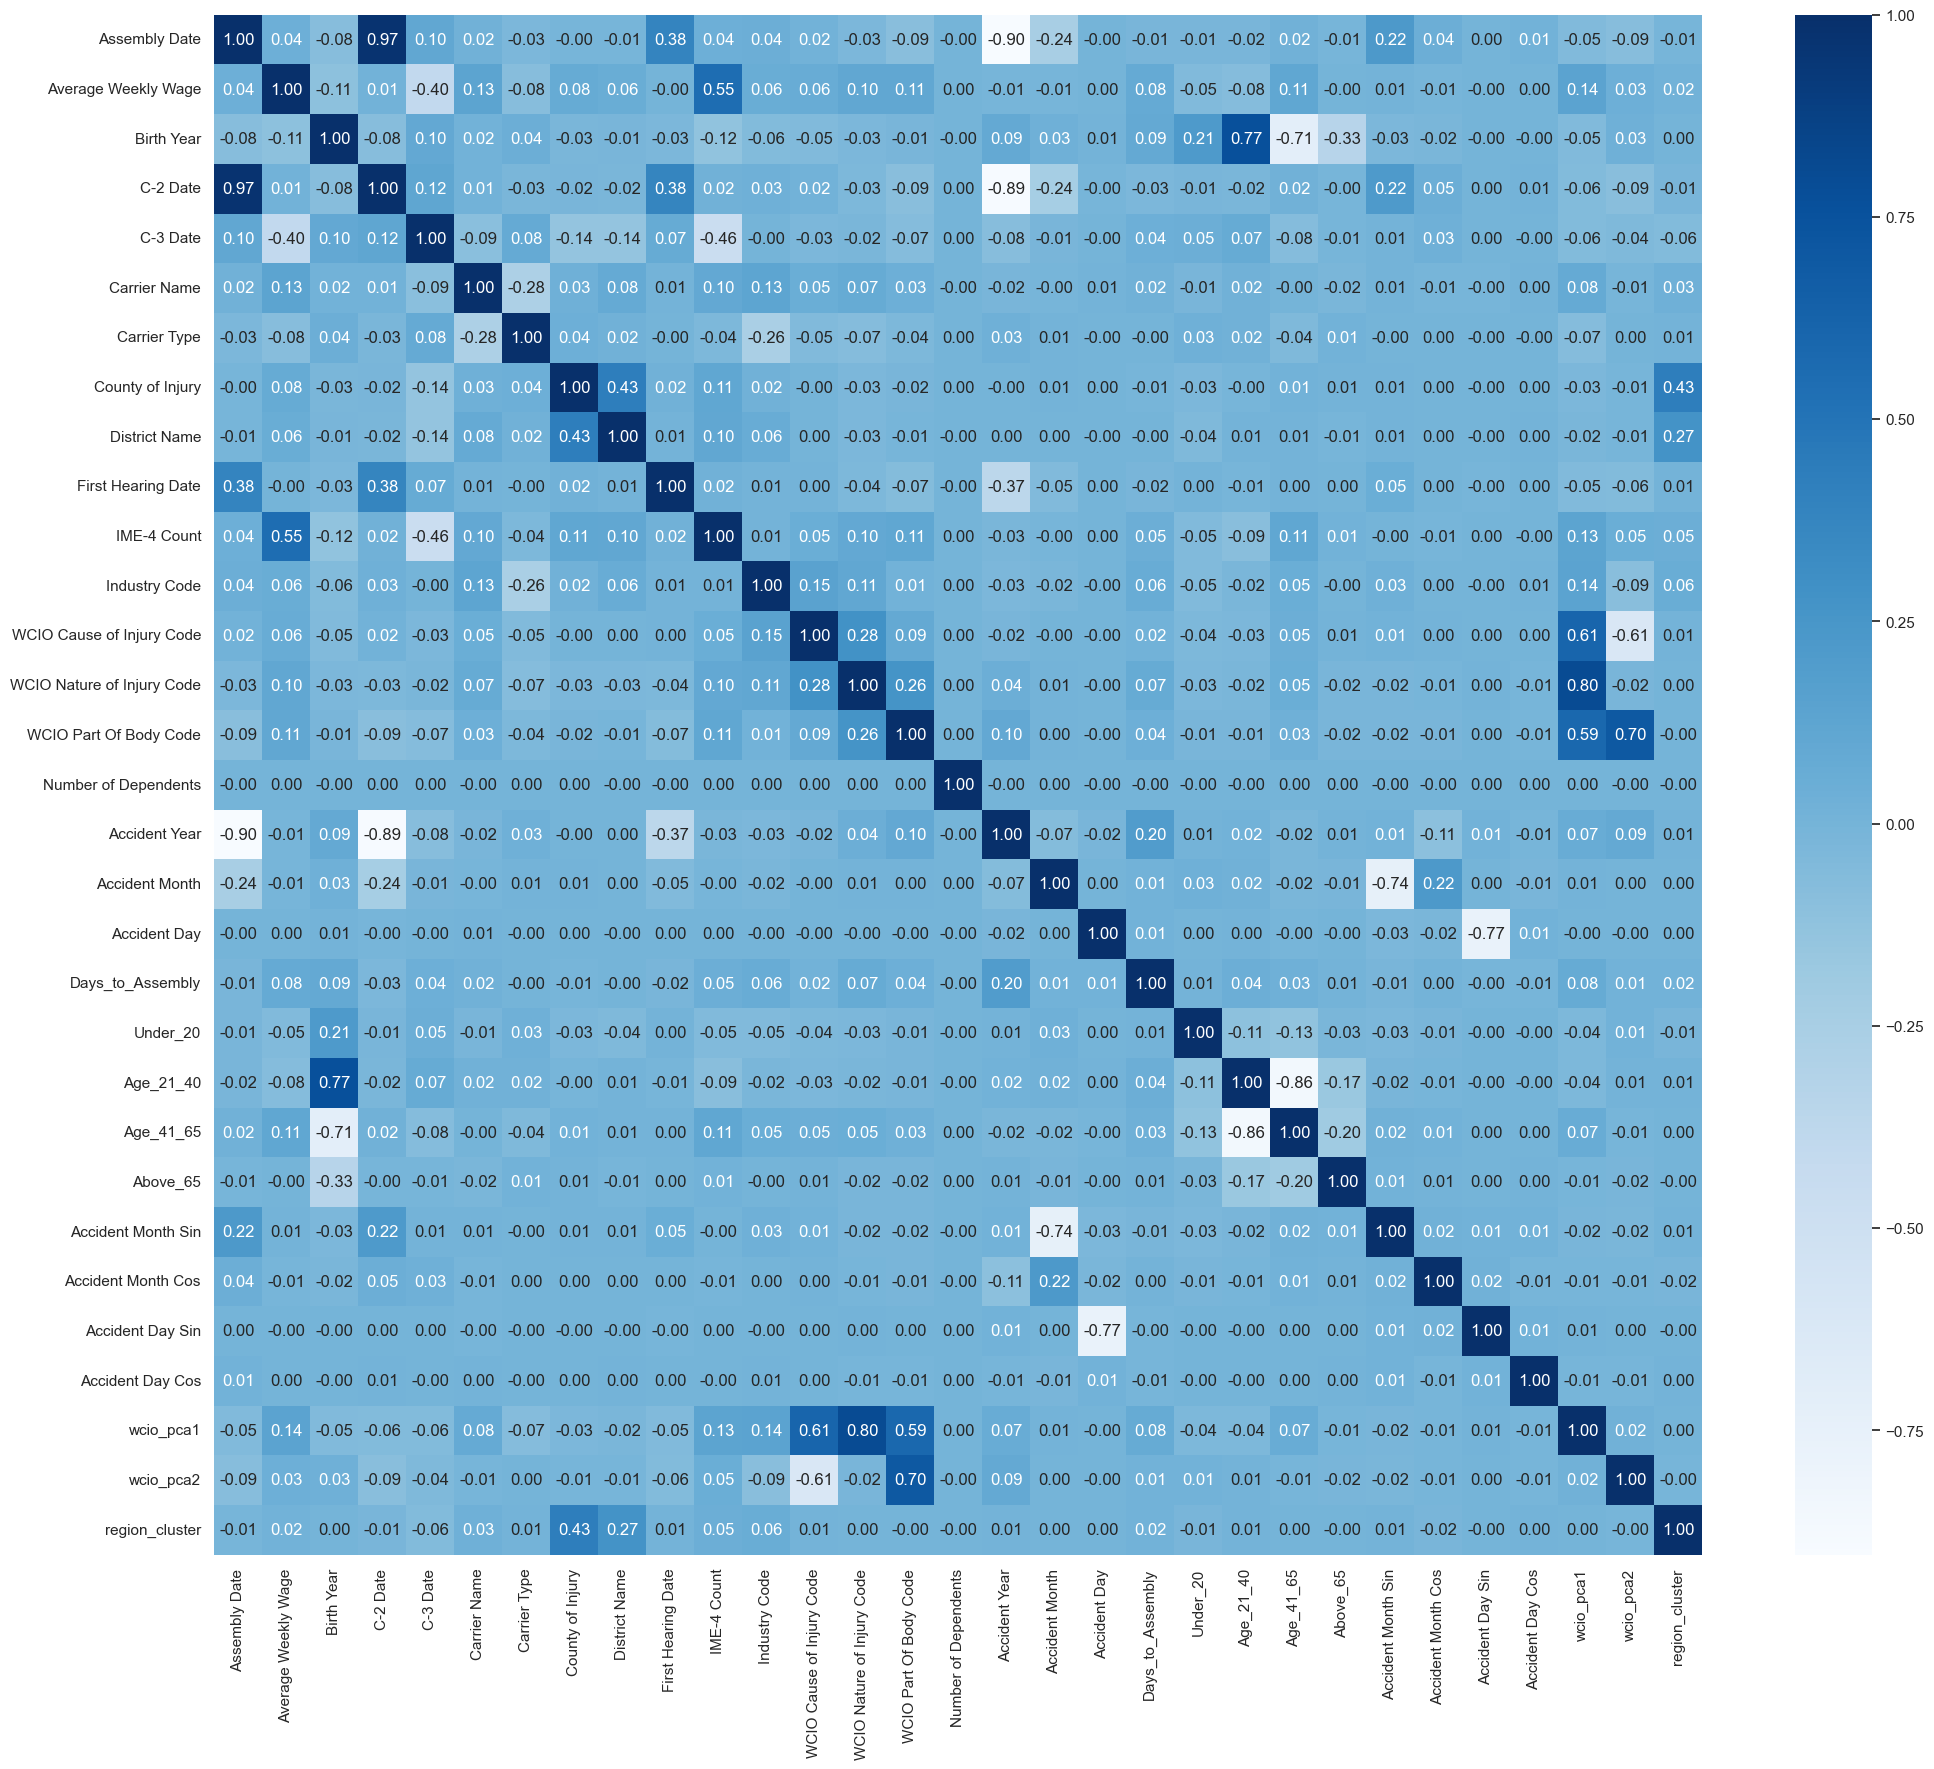

Correlation between Assembly Date and C-2 Date is above 0.8: 0.97
Correlation between C-2 Date and Assembly Date is above 0.8: 0.97
Correlation between WCIO Nature of Injury Code and wcio_pca1 is above 0.8: 0.80
Correlation between wcio_pca1 and WCIO Nature of Injury Code is above 0.8: 0.80


In [27]:
cor_heatmap(cor_spearman)

cor_spearman = continuous_features.corr(method='spearman')

# Filter the correlation matrix
filtered_cor = cor_spearman[
            (cor_spearman > 0.8)
]

# Remove diagonal part
filtered_cor = filtered_cor.mask(np.equal(*np.indices(filtered_cor.shape)))

# Stack the filtered correlation matrix and reset the index
stacked_cor = filtered_cor.stack().reset_index()

# Filter out NaN values and correlations equal to 1
filtered_stacked_cor = stacked_cor[
    stacked_cor[0].notnull() & (stacked_cor[0] != 1)
]

# Print the features and their correlation values with messages
for index, row in filtered_stacked_cor.iterrows():
    feature1 = row['level_0']
    feature2 = row['level_1']
    correlation = row[0]

    if correlation > 0.8:
        print(f"Correlation between {feature1} and {feature2} is above 0.8: {correlation:.2f}")



We will assume that the Thresholds for feature relevance is 0.2 and redundance for 0,8


### Redundancy
drop 'wcio_pca1' or WCIO 'Nature of Injury Code'

drop 'c2 date' or assembly date

drop 'average weekly age or '

### Relevance

Drop Number of depndents




<a class="anchor" id="15th-bullet">

### Mutual Information Classification
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectKBest.html
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.mutual_info_regression.html
</a>

In [11]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

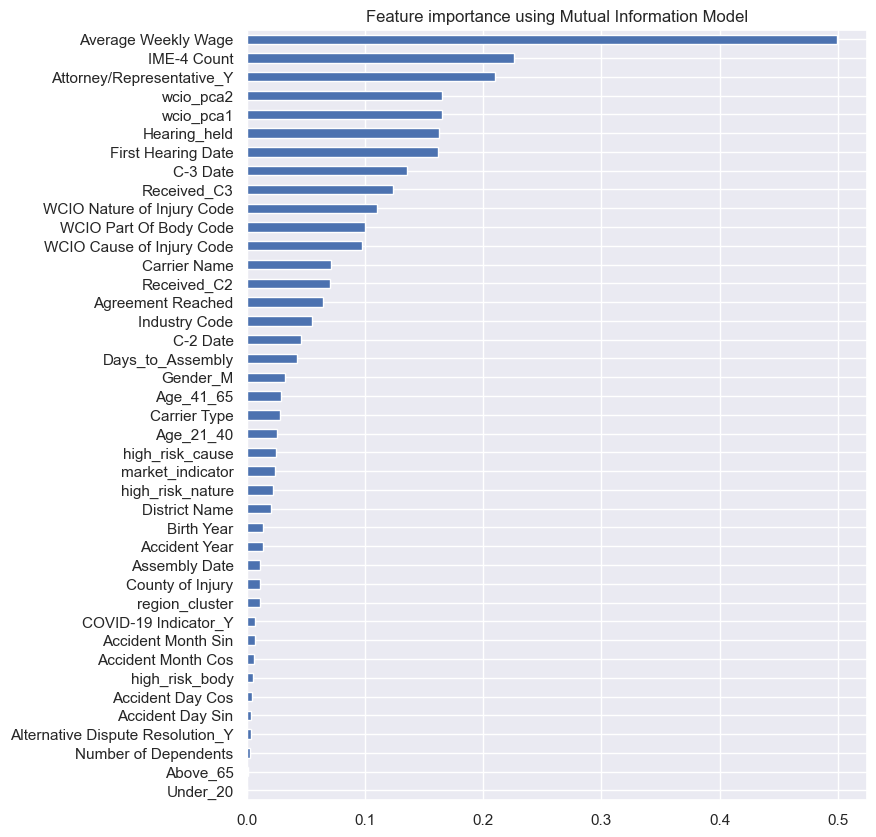

Features to be eliminated: 
Index(['Assembly Date', 'Birth Year', 'County of Injury', 'District Name',
       'Number of Dependents', 'Accident Year', 'Under_20', 'Above_65',
       'Accident Month Sin', 'Accident Month Cos', 'Accident Day Sin',
       'Accident Day Cos', 'COVID-19 Indicator_Y',
       'Alternative Dispute Resolution_Y', 'region_cluster',
       'high_risk_nature', 'high_risk_body', 'market_indicator'],
      dtype='object')


In [46]:
#  Mutual Information Regression for feature selection in regression problems
mic = SelectKBest(score_func= mutual_info_classif, k= 'all')

# fit the model to the training data
mic.fit(X_preproc_train, y_preproc_train)

# get the scores of the features
mic_scores = pd.Series(mic.scores_, index = X_preproc_train.columns)

# plot the scores
plot_importance(mic_scores,'Mutual Information')
mic_scores.sort_values()

#print the features that were eliminated

eliminated_features = mic_scores[mic_scores <= 0.0243].index

print(f"Features to be eliminated: \n{eliminated_features}")

<a class="anchor" id="11th-bullet">

## Wrapper Methods
    
</a>

<a class="anchor" id="12th-bullet">

### RFE
    
</a>

In [28]:
#how many na values are in the dataset
y_preproc_train.isna()

0         False
1         False
2         False
3         False
4         False
          ...  
459215    False
459216    False
459217    False
459218    False
459219    False
Name: Claim Injury Type, Length: 459220, dtype: bool

<a class="anchor" id="13th-bullet">

#### RFE XGBoosting

</a>

Using RFE, the objective is finding the optimal number of features to select

### RFE XGBoosting

In [ ]:
#number of features
nof_list= np.arange(1, 41)
high_score=0

#Variable to store the optimum features
nof=0
train_f1score_list =[]
val_f1score_list = []

for n in range(len(nof_list)):

    #using XGBoost
    model = XGBClassifier(objective='multi:softprob', 
                          random_state=42, 
                          learning_rate=0.075, 
                          max_depth=12,
                          min_child_weight=8, 
                          subsample=0.8, 
                          colsample_bytree=0.6, 
                          n_estimators=2000, 
                          reg_alpha=1.0, 
                            reg_lambda=1.5
)

    rfe = RFECV(estimator = model,min_features_to_select = nof_list[n], step=1, cv=5)
    X_train_rfe = rfe.fit_transform(X_preproc_train[:500],y_preproc_train[:500])
    X_val_rfe = rfe.transform(X_preproc_val[:500])

    model.fit(X_train_rfe[:500],y_preproc_train[:500])

    # Predictions for F1 score
    y_preproc_train_pred = model.predict(X_train_rfe)
    y_preproc_val_pred = model.predict(X_val_rfe)

    #storing results on training data
    train_f1score = f1_score(y_preproc_train[:500],y_preproc_train_pred[:500], average='macro')
    train_f1score_list.append(train_f1score)

    #storing results on training data
    val_f1score = f1_score(y_preproc_val[:500],y_preproc_val_pred[:500], average='macro')
    val_f1score_list.append(val_f1score)

    #check best score
    if(val_f1score >= high_score):
        high_score = val_f1score
        nof = nof_list[n]
        features_to_select = pd.Series(rfe.support_, index = X_preproc_train.columns)


print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")


KeyboardInterrupt: 

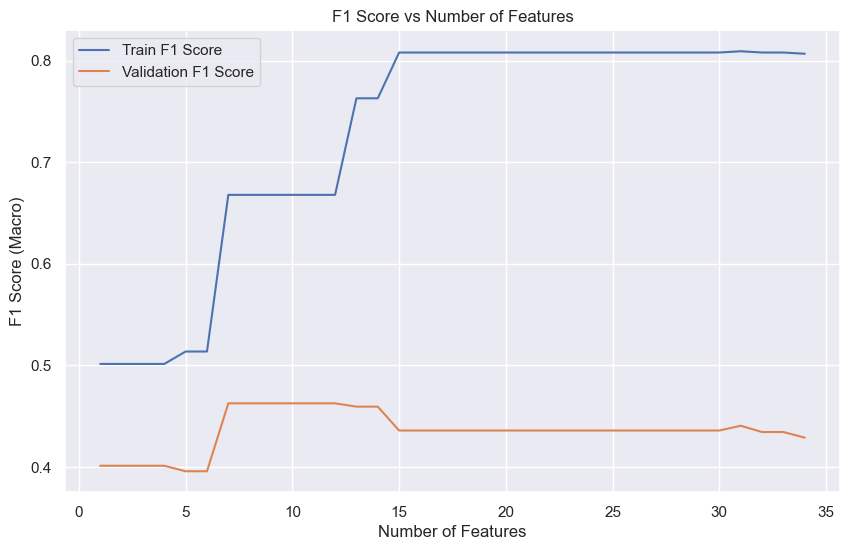

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(nof_list, train_f1score_list, label="Train F1 Score")
plt.plot(nof_list, val_f1score_list, label="Validation F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score (Macro)")
plt.title("F1 Score vs Number of Features")
plt.legend()
plt.show()

<a class="anchor" id="13th-bullet">

## Embedded Methods
    
</a>

<a class="anchor" id="14th-bullet">

### Lasso Regression
    
</a>

In [38]:

reg = LassoCV(cv=10, random_state=42)

reg.fit(X_preproc_train, y_preproc_train)

coef = pd.Series(reg.coef_, index = X_preproc_train.columns)
coef.sort_values()

high_risk_cause                    -0.101294
Accident Year                      -0.041696
District Name                      -0.039443
high_risk_nature                   -0.036231
Assembly Date                      -0.010846
Carrier Type                       -0.007567
Birth Year                         -0.004992
Accident Month Cos                 -0.003828
First Hearing Date                 -0.003057
County of Injury                   -0.002678
region_cluster                     -0.001213
Accident Day Sin                   -0.000531
wcio_pca2                           0.000000
Under_20                            0.000000
COVID-19 Indicator_Y                0.000000
Age_41_65                          -0.000000
high_risk_body                     -0.000000
market_indicator                   -0.000000
WCIO Nature of Injury Code          0.000000
Carrier Name                       -0.000000
Number of Dependents               -0.000000
Accident Day Cos                    0.000787
WCIO Cause

In [41]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
#print the features that were eliminated

features_eliminated = coef[coef == 0]
print(f"Features eliminated: \n{features_eliminated.sort_values()}")

Lasso picked 32 variables and eliminated the other 9 variables
Features eliminated: 
Carrier Name                 -0.0
WCIO Nature of Injury Code    0.0
Number of Dependents         -0.0
Under_20                      0.0
Age_41_65                    -0.0
COVID-19 Indicator_Y          0.0
wcio_pca2                     0.0
high_risk_body               -0.0
market_indicator             -0.0
dtype: float64


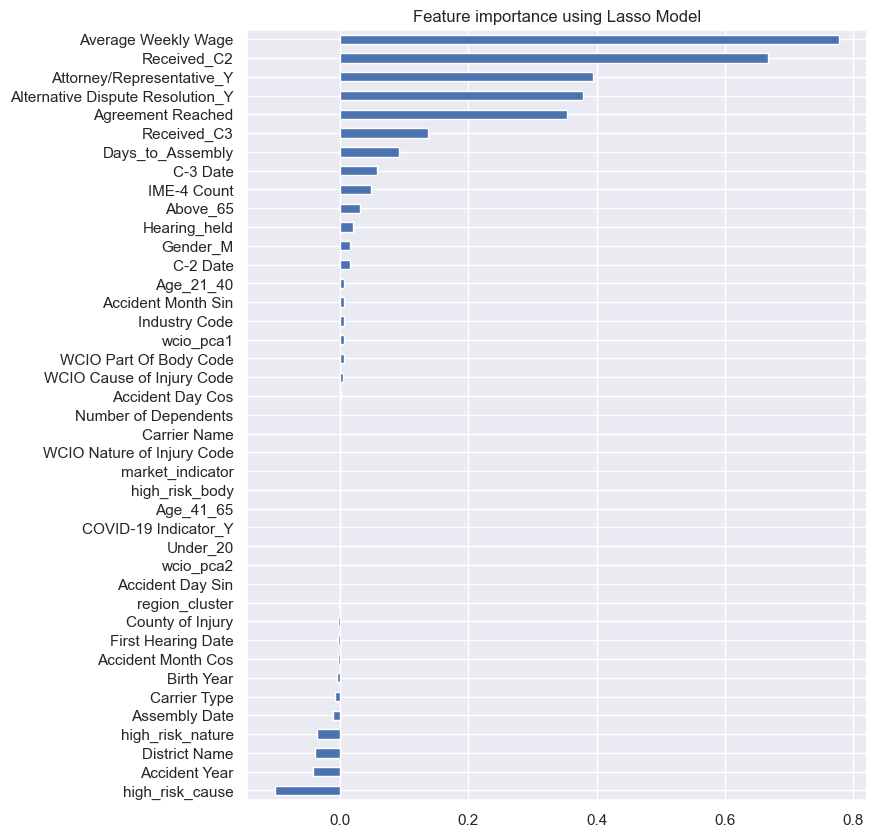

In [42]:
plot_importance(coef,'Lasso')

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

### Numerical Data

| Predictor | Unvariate|  Spearman | Variance information factor (VIF)| (IG)Information Gain | Feature Imprtance XGB (SHAP)| RFE XGB | Lasso | Mutual Information Class. | What to do? |
| --- | --- | --- | --- |--- |---|---|---|---| ---|
| Age at Injury | Keep | --- | --- |--- |---|---|---|---| ---|
| Assembly Date | Keep | --- | --- |--- |---|---|---|---| ---|
| Average Weekly Wage | Keep | --- | --- |--- |---|---|---|---| ---|
| Birth Year | Keep | --- | --- |--- |---|---|---|---| ---|
| C-2 Date | Keep | --- | --- |--- |---|---|---|---| ---|
| C-3 Date | Keep | --- | --- |--- |---|---|---|---| ---|
| Carrier Name | Keep | --- | --- |--- |---|---|---|---| ---|
| Carrier Type | Keep | --- | --- |--- |---|---|---|---| ---|
| County of Injury | Keep | --- | --- |--- |---|---|---|---| ---|
10| District Name | Keep | --- | --- |--- |---|---|---|---| ---|
| First Hearing Date | Keep | --- | --- |--- |---|---|---|---| ---|
| IME-4 Count | Keep | --- | --- |--- |---|---|---|---| ---|
| Industry Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Medical Fee Region | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Cause of Injury Code | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Nature of Injury Code | Keep | --- | --- |--- |---|---|---|---| ---|
| WCIO Part Of Body Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Zip Code | Keep | --- | --- |--- |---|---|---|---| ---|
| Agreement Reached | Keep | --- | --- |--- |---|---|---|---| ---|
20| Number of Dependents | Keep | --- | --- |--- |---|---|---|---| ---|
| Accident Year | Keep | --- | --- |--- |---|---|---|---| ---|
| Received_C2 | Keep | --- | --- |--- |---|---|---|---| ---|
| Received_C3 | Keep | --- | --- |--- |---|---|---|---| ---|
| Hearing_held | Keep | --- | --- |--- |---|---|---|---| ---|
| Attorney/Representative_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| COVID-19 Indicator_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| Alternative Dispute Resolution_Y | Keep | --- | --- |--- |---|---|---|---| ---|
| Gender_M | Keep | --- | --- |--- |---|---|---|---| ---|
| wcio_pca1 | Keep | --- | --- |--- |---|---|---|---| ---|
30| wcio_pca2 | Keep | --- | --- |--- |---|---|---|---| ---|
| region_cluster | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_nature | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_body | Keep | --- | --- |--- |---|---|---|---| ---|
| high_risk_cause | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
40| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
| market_indicator | Keep | --- | --- |--- |---|---|---|---| ---|
<hr>


